

**AutoEncoder**

Autoencoders are artificial neural networks capable of learning dense representations of the input data, called latent representations or codings, without any supervision". This Neural Network architecture is divided into the encoder structure, the decoder structure, and the latent space, also known as the “bottleneck”.

# Setup

In [ ]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms


In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [ ]:
import sys

if not torch.cuda.is_available():
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    device = "cpu"
else:
    device = "cuda"

No GPU was detected. Neural nets can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


In [ ]:
tensor_transform = transforms.ToTensor()

train_ds = datasets.MNIST(root = "./data",
						train = True,
						download = True,
						transform = tensor_transform)

train_dl = torch.utils.data.DataLoader(dataset = train_ds,
									batch_size = 32,
									shuffle = True)

100%|██████████| 9912422/9912422 [00:00<00:00, 77324409.63it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 29049327.06it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 140370037.89it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3367602.75it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#Stacked AutoEncoder

In [ ]:
stacked_encoder = nn.Sequential(
                nn.Linear(28 * 28, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 36),
                nn.ReLU(),
                nn.Linear(36, 18),
                nn.ReLU(),
                nn.Linear(18, 9)
            )

stacked_decoder = nn.Sequential(
                nn.Linear(9, 18),
                nn.ReLU(),
                nn.Linear(18, 36),
                nn.ReLU(),
                nn.Linear(36, 64),
                nn.ReLU(),
                nn.Linear(64, 128),
                nn.ReLU(),
                nn.Linear(128, 28 * 28),
                nn.Sigmoid()
            )

stacked_ae = nn.Sequential(
    stacked_encoder,
    stacked_decoder
)

In [ ]:
stacked_ae.to(device)
stacked_ae

Sequential(
  (0): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=36, bias=True)
    (5): ReLU()
    (6): Linear(in_features=36, out_features=18, bias=True)
    (7): ReLU()
    (8): Linear(in_features=18, out_features=9, bias=True)
  )
  (1): Sequential(
    (0): Linear(in_features=9, out_features=18, bias=True)
    (1): ReLU()
    (2): Linear(in_features=18, out_features=36, bias=True)
    (3): ReLU()
    (4): Linear(in_features=36, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=784, bias=True)
    (9): Sigmoid()
  )
)

In [ ]:
learning_rate = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(stacked_ae.parameters(), lr=0.001)

In [ ]:
from tqdm import tqdm

epochs = 20

outputs = []


for epoch in range(epochs):

    train_loss = 0.0
    for (image, _) in tqdm(train_dl):

        # Reshaping the image to (-1, 784)
        image = image.reshape(-1, 28*28)
        image = image.to(device)
        reconstructed = stacked_ae(image)
        loss = criterion(reconstructed, image)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}: train loss: {train_loss/len(train_dl)}")


In [ ]:
import numpy as np

@torch.no_grad()
def plot_reconstructions(model, images, n_images=5):
    reconstructions = model(images[:n_images])
    images = images.to("cpu").reshape(-1, 28, 28)
    reconstructions = reconstructions.to("cpu").reshape(-1, 28, 28)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")


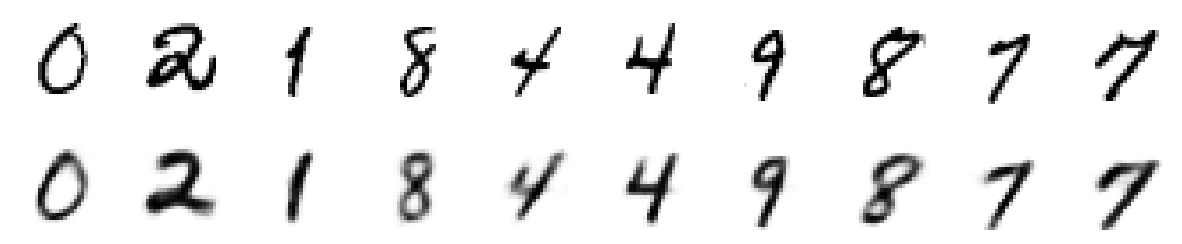

In [ ]:
plot_reconstructions(stacked_ae, image, 10)
plt.show()

#Denoising AutoEncoder

In [ ]:
dropout_encoder = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(28 * 28, 100),
                nn.ReLU(),
                nn.Linear(100, 30),
                nn.ReLU(),
            )

dropout_decoder = nn.Sequential(
                nn.Linear(30, 100),
                nn.ReLU(),
                nn.Linear(100, 28 * 28),
                nn.Sigmoid()
            )

dropout_ae = nn.Sequential(
    dropout_encoder,
    dropout_decoder
)

In [ ]:
dropout_ae.to(device)
dropout_ae

Sequential(
  (0): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=784, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=30, bias=True)
    (4): ReLU()
  )
  (1): Sequential(
    (0): Linear(in_features=30, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

In [ ]:
learning_rate = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(dropout_ae.parameters(), lr=0.001)

In [ ]:
from tqdm import tqdm

epochs = 10

for epoch in range(epochs):

    train_loss = 0.0
    for (image, _) in tqdm(train_dl):

        # Reshaping the image to (-1, 784)
        image = image.reshape(-1, 28*28)
        image = image.to(device)
        reconstructed = dropout_ae(image)
        loss = criterion(reconstructed, image)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}: train loss: {train_loss/len(train_dl)}")

100%|██████████| 1875/1875 [00:23<00:00, 80.18it/s]


Epoch 1/10: train loss: 0.03693383064766725


100%|██████████| 1875/1875 [00:21<00:00, 88.30it/s]


Epoch 2/10: train loss: 0.023353443736831347


100%|██████████| 1875/1875 [00:25<00:00, 73.25it/s]


Epoch 3/10: train loss: 0.020781333463887372


100%|██████████| 1875/1875 [00:20<00:00, 91.41it/s]


Epoch 4/10: train loss: 0.019287759968141714


100%|██████████| 1875/1875 [00:19<00:00, 95.44it/s] 


Epoch 5/10: train loss: 0.01840027598043283


100%|██████████| 1875/1875 [00:18<00:00, 99.51it/s]


Epoch 6/10: train loss: 0.017661538577079774


100%|██████████| 1875/1875 [00:19<00:00, 94.16it/s] 


Epoch 7/10: train loss: 0.017117177011072637


100%|██████████| 1875/1875 [00:18<00:00, 98.71it/s] 


Epoch 8/10: train loss: 0.016697203817466894


100%|██████████| 1875/1875 [00:19<00:00, 95.04it/s] 


Epoch 9/10: train loss: 0.01634158610055844


100%|██████████| 1875/1875 [00:19<00:00, 97.25it/s]

Epoch 10/10: train loss: 0.016095110263923806


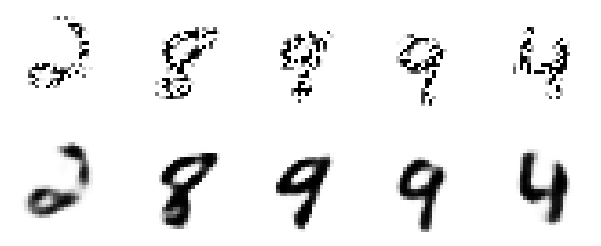

In [ ]:
dropout = nn.Dropout(0.5)
plot_reconstructions(dropout_ae, dropout(image))
plt.show()

#Convolutional AutoEncoder

In [ ]:
conv_encoder = nn.Sequential(
    nn.Conv2d(1, 16, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),  # output = 14 * 14 * 16
    nn.Conv2d(16, 32, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 64, 3, padding=1),  # output = 7 * 7 * 32
    nn.ReLU(),
    nn.MaxPool2d(2, 2),  # output = 3 * 3 * 64
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten()
)

conv_decoder = nn.Sequential(
    nn.Linear(64, 3 * 3 * 64),
    nn.Unflatten(1, (64, 3, 3)),
    nn.ConvTranspose2d(64, 32, 3, stride=2), # output = 32 * 7 * 7
    nn.ReLU(),
    nn.ConvTranspose2d(32, 16, 3, padding=1, stride=2), # outout = 16 * 14 * 14
    nn.ReLU(),
    nn.ConvTranspose2d(16, 1, 3, stride=2, output_padding=1),  # output =  1 * 28 * 28
    nn.Sigmoid()
)

conv_ae = nn.Sequential(
    conv_encoder,
    conv_decoder
)

In [ ]:
learning_rate = 0.001

conv_ae = conv_ae.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(conv_ae.parameters(), lr=0.001)

In [ ]:
from tqdm import tqdm

epochs = 10

outputs = []


for epoch in range(epochs):

    train_loss = 0.0
    for (image, _) in tqdm(train_dl):

        # Reshaping the image to (-1, 784)
        image = image.to(device)
        reconstructed = conv_ae(image)
        loss = criterion(reconstructed.view(-1, 28 * 28), image.view(-1, 28 * 28))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}: train loss: {train_loss/len(train_dl)}")

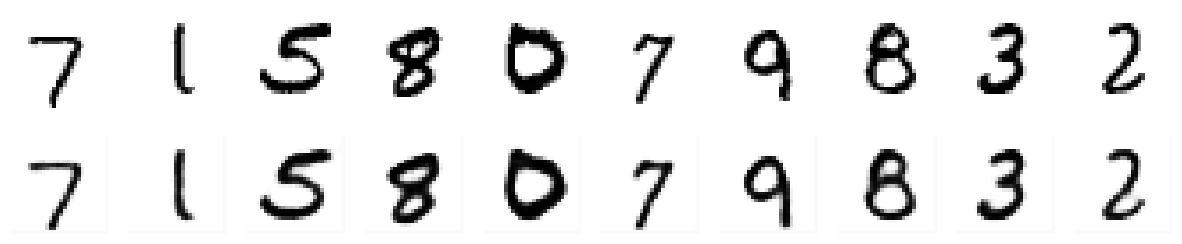

In [ ]:
plot_reconstructions(conv_ae, image, 10)
plt.show()

# VAE

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_size, latent_size, device="cuda"):
        super().__init__()
        self.device = device
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU()
        )

        self.mean_layer = nn.Linear(100, latent_size)
        self.logvar_layer = nn.Linear(100, latent_size)

        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 100),
            nn.ReLU(),
            nn.Linear(100, 300),
            nn.ReLU(),
            nn.Linear(300, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):

        enc_out = self.encoder(x)
        mean, logvar = self.mean_layer(enc_out), self.logvar_layer(enc_out)
        eps = torch.randn_like(mean).to(self.device)
        z = eps * logvar + mean
        return self.decoder(z), mean, logvar


In [ ]:
input = torch.randn(3, 2, requires_grad=True)
input

tensor([[-2.1017,  1.7373],
        [ 0.2823,  0.5623],
        [ 1.6486, -0.8809]], requires_grad=True)

In [ ]:
target = torch.rand(3, 2, requires_grad=False)
target

tensor([[0.2693, 0.7702],
        [0.1572, 0.5324],
        [0.3992, 0.2126]])

In [ ]:
m = nn.Sigmoid()
loss = F.binary_cross_entropy(m(input), target, reduction='none')
# loss
# torch.sum(loss, dim=(1))
# torch.mean(torch.sum(loss, dim=(1)))

tensor(1.4856, grad_fn=<MeanBackward0>)

In [ ]:
mean_loss = torch.mean(torch.sum(loss, dim=(1, 2)))

In [ ]:
# custom loss function
class VAELoss(nn.Module):
    def forward(self, reconstruction, x, mean, logvar):
        loss_reconstruction = F.binary_cross_entropy(reconstruction, x, reduction='none')
        loss_kld = -0.5 * torch.sum(1 + logvar - logvar.exp() - mean.pow(2), dim=(1))
        return torch.mean(torch.sum(loss_reconstruction, dim=(1))) + torch.mean(loss_kld)

In [ ]:
learning_rate = 0.001

model = VAE(784, 2, device=device).to(device)
criterion = VAELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from tqdm import tqdm

epochs = 20

for epoch in range(epochs):

    train_loss = 0.0
    for (image, _) in tqdm(train_dl):

        # Reshaping the image to (-1, 784)
        image = image.to(device)
        reconstructed, mean, logvar = model(image)
        loss = criterion(reconstructed, image.view(-1, 784), mean, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}: train loss: {train_loss/len(train_dl)}")

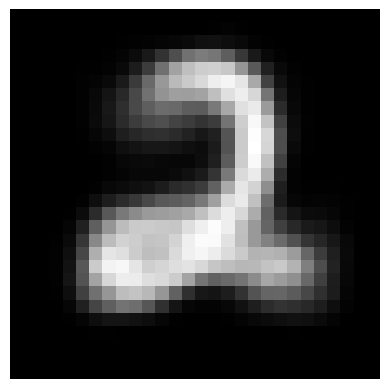

In [ ]:
x = torch.tensor([1.0, 0.0]).to(device)
img = model.decoder(x)
img = img.detach().cpu().reshape(28, 28)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

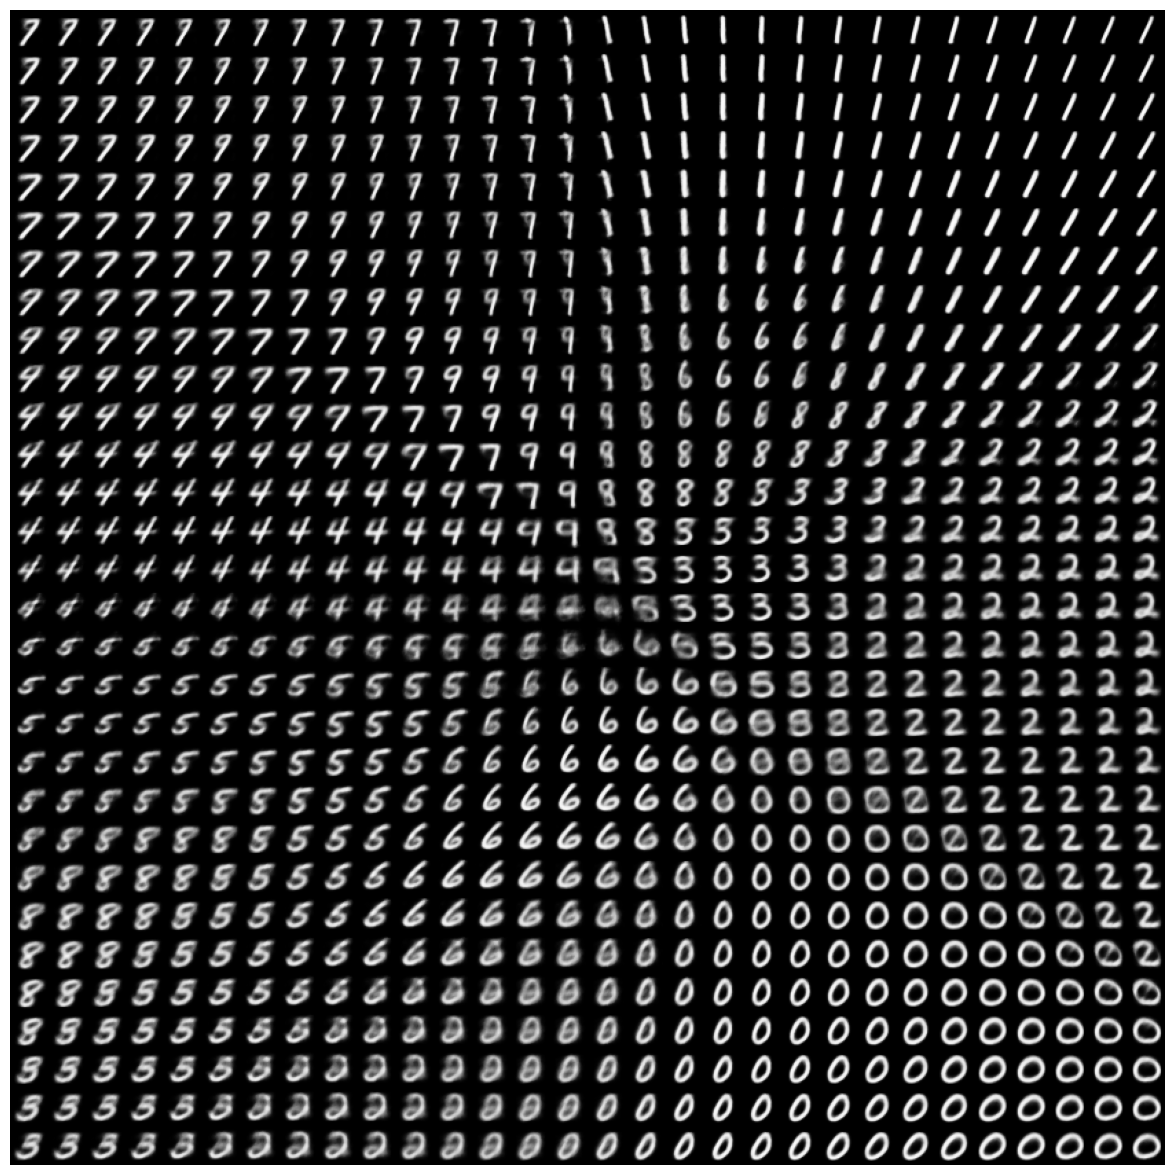

In [ ]:
import numpy as np

#Grid of 30 × 30 digits (900 digits total)
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

#Sample points linearly on a 2D grid
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

#Iterate over grid locations
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = torch.tensor([[xi, yi]]).float()
        x_decoded = model.decoder(z_sample).detach().cpu()
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size : (i + 1) * digit_size,j * digit_size : (j + 1) * digit_size,] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")